# Ensemble

In [6]:
# For model testing purposes, faster runtime for 455 row x 5 columns
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, log_loss
from yellowbrick.classifier import ClassificationReport
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time

iris = datasets.load_breast_cancer()
X = pd.DataFrame(iris.data[:, :5])  # we only take the first five features.
y = pd.DataFrame(iris.target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(y_train[0].unique()) # binary classfication
X_train

[1 0]


,0,1,2,3,4
269,10.710,20.39,69.50,344.9,0.10820
489,16.690,20.20,107.10,857.6,0.07497
365,20.440,21.78,133.80,1293.0,0.09150
28,15.300,25.27,102.40,732.4,0.10820
294,12.720,13.78,81.78,492.1,0.09667
...,...,...,...,...,...
440,10.970,17.20,71.73,371.5,0.08915
167,16.780,18.80,109.30,886.3,0.08865
504,9.268,12.87,61.49,248.7,0.16340
299,10.510,23.09,66.85,334.2,0.10150


In [27]:
def create_pipe_ensemble(X_train, ensemble_clf, clf_label='clf'):
    """
    https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf
    Returns an sklearn model pipeline.
    """
    pipe = Pipeline([(clf_label, VotingClassifier(estimators=[
                          (clf_label+str(1), create_pipe(X_train, ensemble_clf.estimators[0][1])),
                          (clf_label+str(2), create_pipe(X_train, ensemble_clf.estimators[1][1])),
                          (clf_label+str(3), create_pipe(X_train, ensemble_clf.estimators[2][1])),
                          (clf_label+str(4), create_pipe(X_train, ensemble_clf.estimators[3][1])),
                          (clf_label+str(5), create_pipe(X_train, ensemble_clf.estimators[4][1])),
                          (clf_label+str(6), create_pipe(X_train, ensemble_clf.estimators[5][1])),
                          (clf_label+str(7), create_pipe(X_train, ensemble_clf.estimators[6][1])),
                          (clf_label+str(8), create_pipe(X_train, ensemble_clf.estimators[7][1]))
                                           ]))])
    return pipe

def clfy_report_ensemble(ensemble_voting, X_train, X_test, y_train, y_test, ensemble_params, cv=10):
    """
    Tune classifier hyperparameters and print metrics.
    """
    
    # Instantiate grid search using 10-fold cross validation:
    search = RandomizedSearchCV(ensemble_voting, ensemble_params, cv=cv, n_iter=5)
    
    # Learn relationship between predictors (basketball/tourney features) and outcome,
    # and the best parameters for defining such:
    search.fit(X_train, y_train)
    
    # Predictions on the test set, new data that haven't been introduced to the model:
    predicted = search.predict(X_test)
    
    # Predictions as probabilities:
    probabilities = search.predict_proba(X_test)[:, 1]
    
    # Accuracy scores for the training and test sets:
    train_accuracy = search.score(X_train, y_train)
    test_accuracy = search.score(X_test, y_test)

    print('Best Parameters: {}\n'.format(search.best_params_))
    print('Training Accuracy: {:0.2}'.format(train_accuracy))
    print('Test Accuracy: {:0.2}\n'.format(test_accuracy))
    
    # Confusion matrix labels:
    labels = np.array([['true losses','false wins'], ['false losses','true wins']])
    
    # Model evaluation metrics:
    confusion_mtrx = confusion_matrix(y_test, predicted)
    auc = roc_auc_score(y_test, probabilities)
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    logloss = log_loss(y_test, search.predict_proba(X_test))
    
    # Plot all metrics in a grid of subplots:
    fig = plt.figure(figsize=(12, 12))
    grid = plt.GridSpec(2, 4, wspace=0.75, hspace=0.5)
    
    # Top-left plot - confusion matrix:
    plt.subplot(grid[0, :2])
    sns.heatmap(confusion_mtrx, annot=True, fmt="d") #, fmt='')
    plt.xlabel('Predicted Games')
    plt.ylabel('Actual Games');
    
    # Top-right plot - ROC curve:
    plt.subplot(grid[0, 2:])
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUROC: {:0.3}'.format(auc));
    
    # Bottom-left plot - support, or true predictions:
    plt.subplot(grid[1, :2])
    sns.countplot(y=predicted, orient='h')
    plt.yticks([1, 0], ('wins', 'losses'))
    plt.ylabel(''), plt.xlabel('Number Predicted');
    
    # Bottom-right plot - classification report:
    plt.subplot(grid[1, 2:])
    visualizer = ClassificationReport(search, classes=['losses', 'wins'])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    g = visualizer.poof();
    
    return search, train_accuracy, test_accuracy, auc, logloss

In [24]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
preprocessor = ColumnTransformer(
    transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)])


classifiers = [
    SVC(probability=True),
    RandomForestClassifier(),
    LogisticRegression(),
    MLPClassifier(),
    GaussianNB(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier()
    ]

pipeline_classifiers=[]
for i in range(0,len(classifiers)):
    pipeline_classifiers.append(Pipeline (steps=[('preprocessor', preprocessor),
        ('clf'+str(i+1), classifiers[i])]))

del classifiers
from sklearn.ensemble import VotingClassifier
ensemble_voting = Pipeline(steps=[('ensemble', VotingClassifier(estimators=[
    ('svc', pipeline_classifiers[0]), 
    ('rdf' , pipeline_classifiers[1]),
    ('lgr' , pipeline_classifiers[2]),
    ('mlp', pipeline_classifiers[3]),
    ('gau', pipeline_classifiers[4]),
    ('ada', pipeline_classifiers[5]), 
    ('gbt', pipeline_classifiers[6]),
    ('xgb', pipeline_classifiers[7])], 
                                voting='soft', 
                                # weights = [1,2,3], 
                                n_jobs=-1))])

import pprint as pp
pp.pprint(sorted(ensemble_voting.get_params().keys())) # used to specify ensemble params, below. 

['ensemble',
 'ensemble__ada',
 'ensemble__ada__clf6',
 'ensemble__ada__clf6__algorithm',
 'ensemble__ada__clf6__base_estimator',
 'ensemble__ada__clf6__learning_rate',
 'ensemble__ada__clf6__n_estimators',
 'ensemble__ada__clf6__random_state',
 'ensemble__ada__memory',
 'ensemble__ada__preprocessor',
 'ensemble__ada__preprocessor__cat',
 'ensemble__ada__preprocessor__cat__imputer',
 'ensemble__ada__preprocessor__cat__imputer__add_indicator',
 'ensemble__ada__preprocessor__cat__imputer__copy',
 'ensemble__ada__preprocessor__cat__imputer__fill_value',
 'ensemble__ada__preprocessor__cat__imputer__missing_values',
 'ensemble__ada__preprocessor__cat__imputer__strategy',
 'ensemble__ada__preprocessor__cat__imputer__verbose',
 'ensemble__ada__preprocessor__cat__memory',
 'ensemble__ada__preprocessor__cat__onehot',
 'ensemble__ada__preprocessor__cat__onehot__categories',
 'ensemble__ada__preprocessor__cat__onehot__drop',
 'ensemble__ada__preprocessor__cat__onehot__dtype',
 'ensemble__ada__pre

Best Parameters: {'ensemble__svc__clf1__kernel': 'sigmoid', 'ensemble__svc__clf1__C': 1e-07}

Training Accuracy: 0.98
Test Accuracy: 0.9



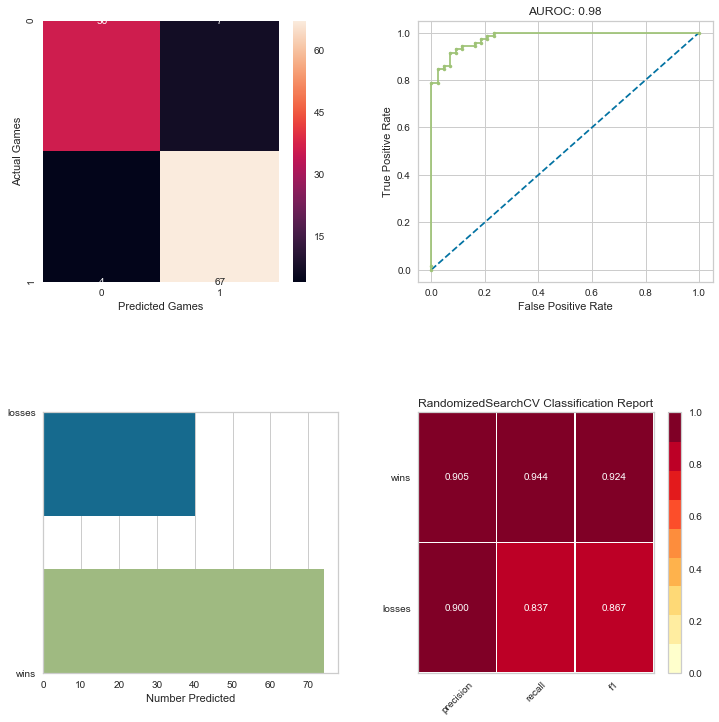

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ensemble',
                                              VotingClassifier(estimators=[('svc',
                                                                            Pipeline(memory=None,
                                                                                     steps=[('preprocessor',
                                                                                             ColumnTransformer(n_jobs=None,
                                                                                                               remainder='drop',
                                                                                                               sparse_threshold=0.3,
                                                                                                               transformer_weights=None,
                                    

In [37]:
ensemble_params=[
    { # SVC
        'ensemble__svc__clf1__kernel': ['rbf', 'linear', 'sigmoid'],
        'ensemble__svc__clf1__C': np.logspace(start=-10, stop=10, num=21) # default 1.0
    },
    { # RandomForestClassifier
        'ensemble__rdf__clf2__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'ensemble__rdf__clf2__max_features': ['sqrt', 'log2'] # The lower the greater the reduction of variance, but also the greater the increase in bias.
    },
    { # LogisticRegression
        'ensemble__lgr__clf3__C': np.logspace(start=-10, stop=10, num=21),
        'ensemble__lgr__clf3__penalty': ['none', 'l2']
    },
    { # Neural network multi-layered perceptron, MLPClassifier
      'ensemble__mlp__clf4__hidden_layer_sizes': tuple(map(tuple, np.random.randint(low=5, high=20, size=(10, 3)))) # from 5-20 nodes per 3 layers, 10 iterations
    },
    { # GaussianNB
        'ensemble__gau__clf5__var_smoothing': [1e-8, 1e-9, 1e-10]
    },
    { # AdaBoostClassifier
        'ensemble__ada__clf6__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'ensemble__ada__clf6__learning_rate': np.linspace(0.5, 1.5, 10, endpoint=True) # default 1.0
    },
    { # GradientBoostingClassifier
        'ensemble__gbt__clf7__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'ensemble__gbt__clf7__learning_rate': np.linspace(0.02, 0.18, 9, endpoint=True) # default 0.1
    },
    { # XGBClassifier
#     'clf__learning_rate': np.logspace(start=0.01, stop=0.2, num=10, endpoint = True), # see last example in np.logspace documentation
    'ensemble__xgb__clf8__max_depth': [2,3,4,5],
    'ensemble__xgb__clf8__booster': ['gbtree', 'gblinear', 'dart']
    }
]

search, train_accuracy, test_accuracy, auc, logloss = clfy_report_ensemble(
    ensemble_voting, X_train, X_test, y_train, y_test, ensemble_params, cv=3)
print(search, train_accuracy, test_accuracy, auc, logloss)


In [29]:
search = RandomizedSearchCV(ensemble_voting, ensemble_params, cv=2, n_iter=5)
    
# Learn relationship between predictors (basketball/tourney features) and outcome,
# and the best parameters for defining such:
search.fit(X_train, y_train)

# Predictions on the test set, new data that haven't been introduced to the model:
predicted = search.predict(X_test)

# Predictions as probabilities:
probabilities = search.predict_proba(X_test)[:, 1]

# Accuracy scores for the training and test sets:
train_accuracy = search.score(X_train, y_train)
test_accuracy = search.score(X_test, y_test)

print('Best Parameters: {}\n'.format(search.best_params_))
print('Training Accuracy: {:0.2}'.format(train_accuracy))
print('Test Accuracy: {:0.2}\n'.format(test_accuracy))

Best Parameters: {'ensemble__gbt__clf7__n_estimators': 177, 'ensemble__gbt__clf7__learning_rate': 0.1}

Training Accuracy: 0.97
Test Accuracy: 0.92



In [33]:
search.param_distributions

[{'ensemble__svc__clf1__kernel': ['rbf', 'linear', 'sigmoid'],
  'ensemble__svc__clf1__C': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
         1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
         1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])},
 {'ensemble__rdf__clf2__n_estimators': array([100, 111, 122, 133, 144, 155, 166, 177, 188, 200]),
  'ensemble__rdf__clf2__max_features': ['sqrt', 'log2']},
 {'ensemble__lgr__clf3__C': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
         1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
         1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
  'ensemble__lgr__clf3__penalty': ['none', 'l2']},
 {'ensemble__mlp__clf4__hidden_layer_sizes': ((16, 15, 11),
   (15, 11, 13),
   (6, 7, 9),
   (15, 18, 11),
   (9, 9, 10),
   (16, 19, 19),
   (16, 10, 18),
   (14, 7, 11),
   (19, 12, 11),
   (14, 7, 13))},
 {'ensemble__gau__clf5__var_smoothing': [1e-08, 1e-09, 1e-10]},
 {'ensemble

In [36]:
search.cv_results_

{'mean_fit_time': array([3.49679279, 3.4732151 , 3.35355568, 3.36651695, 3.40890777]),
 'std_fit_time': array([0.04498982, 0.11818385, 0.00446653, 0.00347936, 0.01494348]),
 'mean_score_time': array([0.05932522, 0.0359025 , 0.04635406, 0.04934978, 0.04934645]),
 'std_score_time': array([0.00649858, 0.00099754, 0.00351238, 0.00050998, 0.00151348]),
 'param_ensemble__ada__clf6__n_estimators': masked_array(data=[166, --, 122, 166, 155],
              mask=[False,  True, False, False, False],
        fill_value='?',
             dtype=object),
 'param_ensemble__ada__clf6__learning_rate': masked_array(data=[0.5, --, 1.5, 1.5, 1.0555555555555556],
              mask=[False,  True, False, False, False],
        fill_value='?',
             dtype=object),
 'param_ensemble__gbt__clf7__n_estimators': masked_array(data=[--, 177, --, --, --],
              mask=[ True, False,  True,  True,  True],
        fill_value='?',
             dtype=object),
 'param_ensemble__gbt__clf7__learning_rate': mask